<a href="https://colab.research.google.com/github/alessioborgi/DL_Project/blob/main/Source/InfoRetrieval.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

==================================================

**Project Name:** Neural inverted index for fast and effective information retrieval\
**Course:** Deep Learning\
**University:** Sapienza Università di Roma

**Authors:**
  - [Alessio Borgi] (<tt>1952442</tt>)
  - [Eugenio Bugli] (<tt>1934824</tt>)
  - [Damiano Imola] (<tt>2109063</tt>)

**Date:** [November 2024 - Completion Date]

==================================================

## 0: INSTALL & IMPORT LIBRARIES

In [1]:
!pip install -q --upgrade pip
!pip install -q pytorch-lightning transformers datasets torch wandb

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 65.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 815.2/815.2 kB 32.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 926.4/926.4 kB 23.3 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2024.10.0 requires fsspec==2024.10.0, but you have fsspec 2024.9.0 which is incompatible.


In [2]:
import torch
import wandb
import numpy as np
from datetime import datetime
import pytorch_lightning as pl
from collections import Counter
import matplotlib.pyplot as plt
import torch.nn.functional as F
from datasets import load_dataset
from pytorch_lightning import Trainer
from torch.utils.data import DataLoader, Dataset
from pytorch_lightning.loggers import WandbLogger
from sklearn.cluster import AgglomerativeClustering
from transformers import AutoModel, AutoTokenizer, AutoTokenizer, AutoModelForSequenceClassification
from pytorch_lightning.callbacks import ModelCheckpoint, EarlyStopping, LearningRateMonitor, StochasticWeightAveraging, DeviceStatsMonitor

wandb.login()
# wandb.login(key="b3bce19a09c51bdf8a19eb3dc58f7c44de929e13") #(ALESSIO)
# wandb.login(key="6d550e12a1b8f716ebe580082f495c01ed2adf6c") #(DAMIANO)
wandb.init(project="IR_DSI", resume="allow")

wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

 ··········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: imola-2109063 (sapienza-imola). Use `wandb login --relogin` to force relogin


## 1: DOWNLOADING DATASET




In [ ]:
# PyTorch Dataset class
class MSMARCODataset(Dataset):
    def __init__(self, data, tokenizer, max_length=128, is_test=False):
        """
        Initialize the dataset for MS MARCO.

        Args:
            data: The dataset split (train, validation, or test).
            tokenizer: The tokenizer instance.
            max_length: Maximum token length for inputs.
            is_test: Flag to indicate if the dataset is a test set (no labels).
        """
        self.data = data
        self.tokenizer = tokenizer
        self.max_length = max_length
        self.is_test = is_test

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        item = self.data[idx]
        query = item["query"]
        # COMMENT (D): bisogna ovviamente cambiarlo
        # soprattutto perchè loro utilizzano anche uno skip dei primi K chunk di un documento per controllare
        # quanto il modello overfitta sui primi chunks (e quindi quando riesce a catturare la semantica del DOCUMENTO INTERO)
        passage = item["passages"]["passage_text"][0]

        # If not test set, fetch the label
        # COMMENT (D): non necessario, grazie al controllo finale
        # label = None if self.is_test else 1 if item["passages"]["is_selected"][0] else 0

        # Tokenize input
        # COMMENT (D): dobbiamo controllare se l'impostazione del tokenizer è corretta
        inputs = self.tokenizer(
            query,
            passage,
            truncation=True,
            padding="max_length",
            max_length=self.max_length,
            return_tensors="pt"
        )

        result = {
            "input_ids": inputs["input_ids"].squeeze(0),
            # COMMENT (D): ci serve anche l'attention mask?
            "attention_mask": inputs["attention_mask"].squeeze(0)
        }

        # Add label only if it's not the test set
        # if not self.is_test:
        #     result["label"] = torch.tensor(label, dtype=torch.long)

        return result

In [ ]:
class MSMarcoDataModule(pl.LightningDataModule):
    def __init__(self, train_data, validation_data, test_data, tokenizer, batch_size=32):
        """
        Data module for handling MS MARCO datasets.

        Args:
            train_data: Training dataset split.
            validation_data: Validation dataset split.
            test_data: Test dataset split.
            tokenizer: The tokenizer instance.
            batch_size: Batch size for data loaders.
        """
        super().__init__()
        self.train_data = train_data
        self.validation_data = validation_data
        self.test_data = test_data
        self.tokenizer = tokenizer
        self.batch_size = batch_size

    def setup(self, stage=None):
        self.train_dataset = MSMARCODataset(self.train_data, self.tokenizer)
        self.val_dataset = MSMARCODataset(self.validation_data, self.tokenizer)
        self.test_dataset = MSMARCODataset(self.test_data, self.tokenizer, is_test=True)

    def train_dataloader(self):
        return DataLoader(self.train_dataset, batch_size=self.batch_size, shuffle=True)

    def val_dataloader(self):
        return DataLoader(self.val_dataset, batch_size=self.batch_size)

    def test_dataloader(self):
        return DataLoader(self.test_dataset, batch_size=self.batch_size)

In [ ]:
# Load MS MARCO splits
ms_marco_train = load_dataset("microsoft/ms_marco", "v1.1", split="train")
ms_marco_validation = load_dataset("microsoft/ms_marco", "v1.1", split="validation")
ms_marco_test = load_dataset("microsoft/ms_marco", "v1.1", split="test")

README.md:   0%|          | 0.00/9.48k [00:00<?, ?B/s]

validation-00000-of-00001.parquet:   0%|          | 0.00/21.4M [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/175M [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/20.5M [00:00<?, ?B/s]

Generating validation split:   0%|          | 0/10047 [00:00<?, ? examples/s]

Generating train split:   0%|          | 0/82326 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/9650 [00:00<?, ? examples/s]

## 2: DATASET EXPLORATION

In [ ]:
# Function to print dataset characteristics
def print_dataset_info(name, dataset):
    print(f"\nDataset: {name}")
    print("-" * 40)
    print(f"Number of samples: {len(dataset)}")
    print(f"Features: {dataset.features.keys()}")
    print("\nExample:")
    print(dataset[0])

# Print information for each split
print_dataset_info("Train", ms_marco_train)
print_dataset_info("Validation", ms_marco_validation)
print_dataset_info("Test", ms_marco_test)


Dataset: Train
----------------------------------------
Number of samples: 82326
Features: dict_keys(['answers', 'passages', 'query', 'query_id', 'query_type', 'wellFormedAnswers'])

Example:
{'answers': ['Results-Based Accountability is a disciplined way of thinking and taking action that communities can use to improve the lives of children, youth, families, adults and the community as a whole.'], 'passages': {'is_selected': [0, 0, 0, 0, 0, 1, 0, 0, 0, 0], 'passage_text': ["Since 2007, the RBA's outstanding reputation has been affected by the 'Securency' or NPA scandal. These RBA subsidiaries were involved in bribing overseas officials so that Australia might win lucrative note-printing contracts. The assets of the bank include the gold and foreign exchange reserves of Australia, which is estimated to have a net worth of A$101 billion. Nearly 94% of the RBA's employees work at its headquarters in Sydney, New South Wales and at the Business Resumption Site.", "The Reserve Bank of Aust

In [ ]:
# Analyze specific features
def analyze_passages(dataset):
    print("\n--- Passage Analysis ---")
    passage_lengths = [len(p["passage_text"][0]) for p in dataset["passages"]]
    print(f"Number of passages per query: {len(dataset[0]['passages']['passage_text'])}")
    print(f"Average passage length: {sum(passage_lengths) / len(passage_lengths):.2f} characters")
    print(f"Max passage length: {max(passage_lengths)} characters")
    print(f"Min passage length: {min(passage_lengths)} characters")

# Analyze passages in the train set
analyze_passages(ms_marco_train)


--- Passage Analysis ---
Number of passages per query: 10
Average passage length: 414.24 characters
Max passage length: 1167 characters
Min passage length: 43 characters


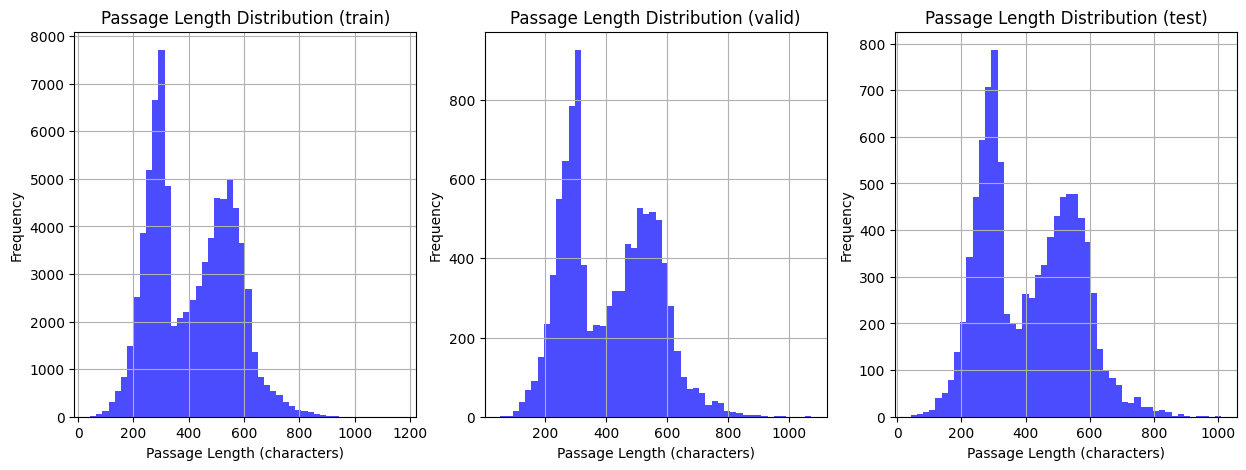

In [ ]:
# # Passage Length Distribution
# def plot_passage_length_distribution(dataset, split_name):
#     passage_lengths = [len(p["passage_text"][0]) for p in dataset["passages"]]
#     plt.hist(passage_lengths, bins=50, alpha=0.7, color="blue")
#     plt.title(f"Passage Length Distribution ({split_name})")
#     plt.xlabel("Passage Length (characters)")
#     plt.ylabel("Frequency")
#     plt.grid(True)
#     plt.show()

# Plot distribution for train, validation, and test splits
# plot_passage_length_distribution(ms_marco_train, "Train")
# plot_passage_length_distribution(ms_marco_validation, "Validation")
# plot_passage_length_distribution(ms_marco_test, "Test")


def plot_passages_length_distribution(dataset_dict):
    fig, axes = plt.subplots(nrows=1, ncols=len(dataset_dict.keys()), figsize=(15, 5))

    for i, split_name in enumerate(dataset_dict.keys()):
        ax = axes[i]
        dataset = dataset_dict[split_name]
        passage_lengths = [len(p["passage_text"][0]) for p in dataset["passages"]]
        ax.hist(passage_lengths, bins=50, alpha=0.7, color="blue")
        ax.set_title(f"Passage Length Distribution ({split_name})")
        ax.set_xlabel("Passage Length (characters)")
        ax.set_ylabel("Frequency")
        ax.grid(True)

    plt.show()

plot_passages_length_distribution({"train": ms_marco_train, "valid": ms_marco_validation, "test": ms_marco_test})

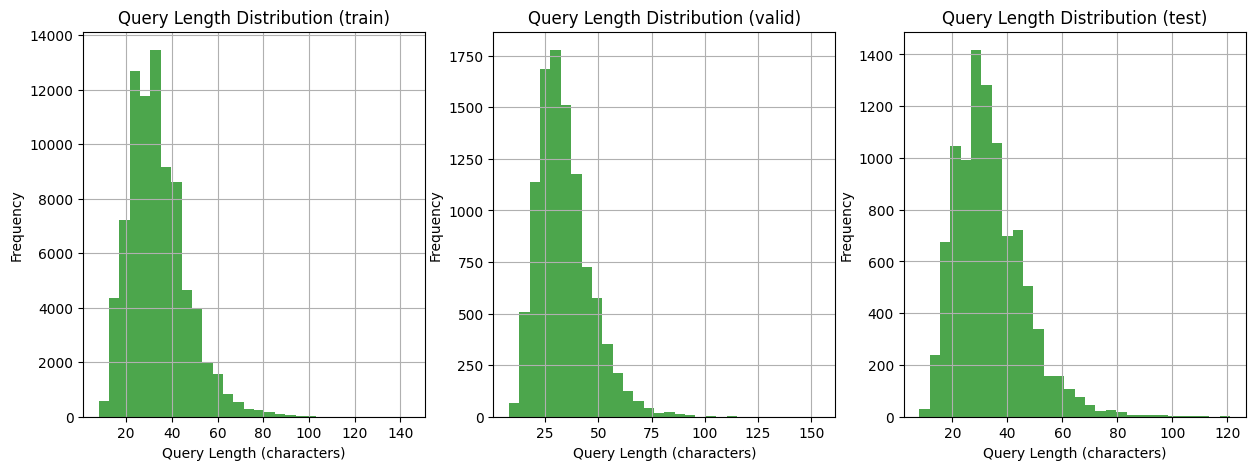

In [ ]:
# # Query Length Distribution
# def plot_query_length_distribution(dataset, split_name):
#     query_lengths = [len(q) for q in dataset["query"]]
#     plt.hist(query_lengths, bins=30, alpha=0.7, color="green")
#     plt.title(f"Query Length Distribution ({split_name})")
#     plt.xlabel("Query Length (characters)")
#     plt.ylabel("Frequency")
#     plt.grid(True)
#     plt.show()

# # Plot distribution for train, validation, and test splits
# plot_query_length_distribution(ms_marco_train, "Train")
# plot_query_length_distribution(ms_marco_validation, "Validation")
# plot_query_length_distribution(ms_marco_test, "Test")

def plot_passages_length_distribution(dataset_dict):
    fig, axes = plt.subplots(nrows=1, ncols=len(dataset_dict.keys()), figsize=(15, 5))

    for i, split_name in enumerate(dataset_dict.keys()):
        ax = axes[i]
        dataset = dataset_dict[split_name]
        query_lengths = [len(q) for q in dataset["query"]]
        ax.hist(query_lengths, bins=30, alpha=0.7, color="green")
        ax.set_title(f"Query Length Distribution ({split_name})")
        ax.set_xlabel("Query Length (characters)")
        ax.set_ylabel("Frequency")
        ax.grid(True)

    plt.show()

plot_passages_length_distribution({"train": ms_marco_train, "valid": ms_marco_validation, "test": ms_marco_test})

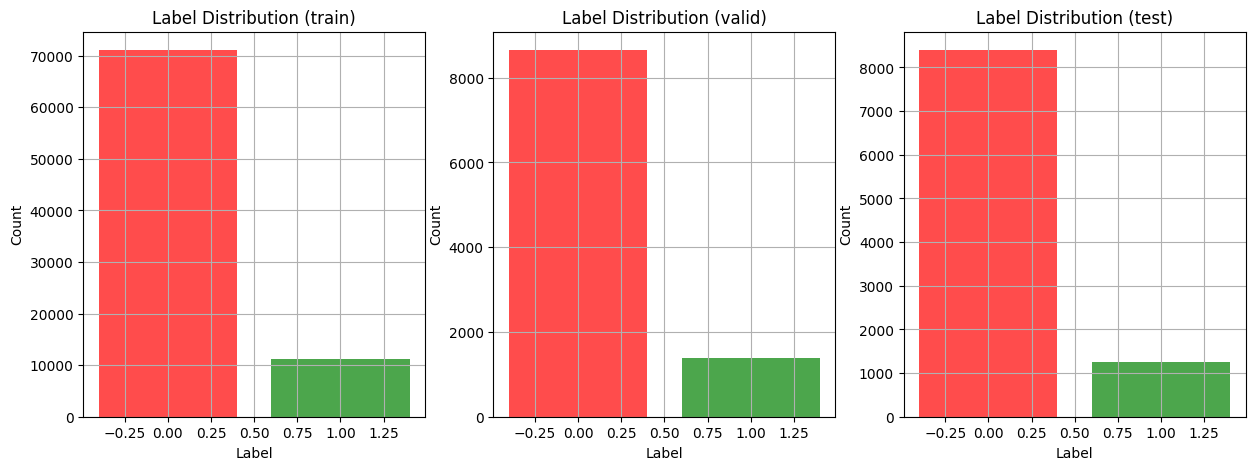

In [ ]:
# # Label Distribution
# def plot_label_distribution(dataset, split_name):
#     labels = [1 if p["is_selected"][0] else 0 for p in dataset["passages"]]
#     label_counts = {0: labels.count(0), 1: labels.count(1)}

#     plt.bar(label_counts.keys(), label_counts.values(), alpha=0.7, color=["red", "green"])
#     plt.xticks([0, 1], ["Not Selected", "Selected"])
#     plt.title(f"Label Distribution ({split_name})")
#     plt.xlabel("Label")
#     plt.ylabel("Count")
#     plt.show()

#     print(f"Label Counts ({split_name}): {label_counts}")

# # Plot label distribution for train and validation splits
# plot_label_distribution(ms_marco_train, "Train")
# plot_label_distribution(ms_marco_validation, "Validation")



def plot_label_distribution(dataset_dict):
    fig, axes = plt.subplots(nrows=1, ncols=len(dataset_dict.keys()), figsize=(15, 5))

    for i, split_name in enumerate(dataset_dict.keys()):
        ax = axes[i]
        dataset = dataset_dict[split_name]
        labels = [1 if p["is_selected"][0] else 0 for p in dataset["passages"]]
        label_counts = {0: labels.count(0), 1: labels.count(1)}
        ax.bar(label_counts.keys(), label_counts.values(), alpha=0.7, color=["red", "green"])
        ax.set_title(f"Label Distribution ({split_name})")
        ax.set_xlabel("Label")
        ax.set_ylabel("Count")
        ax.grid(True)

    plt.show()

plot_label_distribution({"train": ms_marco_train, "valid": ms_marco_validation, "test": ms_marco_test})

In [ ]:
# Unique Queries and Passages
def print_unique_counts(dataset, split_name):
    unique_queries = len(set(dataset["query"]))
    unique_passages = len(set([p["passage_text"][0] for p in dataset["passages"]]))
    print(f"Unique Queries in {split_name}: {unique_queries}")
    print(f"Unique Passages in {split_name}: {unique_passages}")

# Print unique counts for train, validation, and test splits
print_unique_counts(ms_marco_train, "Train")
print_unique_counts(ms_marco_validation, "Validation")
print_unique_counts(ms_marco_test, "Test")

Unique Queries in Train: 82326
Unique Passages in Train: 81230
Unique Queries in Validation: 10047
Unique Passages in Validation: 10019
Unique Queries in Test: 9650
Unique Passages in Test: 9629


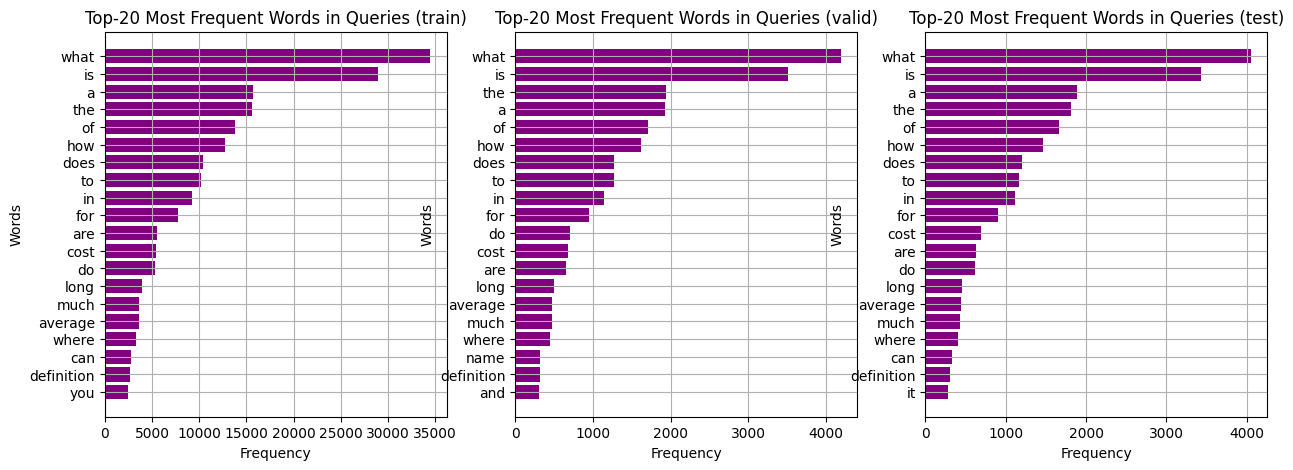

In [ ]:
# # Top-N Most Frequent Words in Queries
# def plot_top_words_in_queries(dataset, split_name, top_n=20):
#     all_queries = " ".join(dataset["query"])
#     word_counts = Counter(all_queries.split())
#     most_common_words = word_counts.most_common(top_n)

#     words, counts = zip(*most_common_words)
#     plt.barh(words, counts, color="purple")
#     plt.gca().invert_yaxis()
#     plt.title(f"Top-{top_n} Most Frequent Words in Queries ({split_name})")
#     plt.xlabel("Frequency")
#     plt.ylabel("Words")
#     plt.show()

# # Plot top-20 words for train, validation, and test splits
# plot_top_words_in_queries(ms_marco_train, "Train")
# plot_top_words_in_queries(ms_marco_validation, "Validation")
# plot_top_words_in_queries(ms_marco_test, "Test")



def plot_top_words_in_queries(dataset_dict, top_n=20):
    fig, axes = plt.subplots(nrows=1, ncols=len(dataset_dict.keys()), figsize=(15, 5))

    for i, split_name in enumerate(dataset_dict.keys()):
        ax = axes[i]
        dataset = dataset_dict[split_name]
        all_queries = " ".join(dataset["query"])
        word_counts = Counter(all_queries.split())
        most_common_words = word_counts.most_common(top_n)

        words, counts = zip(*most_common_words)
        ax.barh(words, counts, color="purple")
        ax.invert_yaxis()
        ax.set_title(f"Top-{top_n} Most Frequent Words in Queries ({split_name})")
        ax.set_xlabel("Frequency")
        ax.set_ylabel("Words")
        ax.grid(True)

    plt.show()

plot_top_words_in_queries({"train": ms_marco_train, "valid": ms_marco_validation, "test": ms_marco_test})

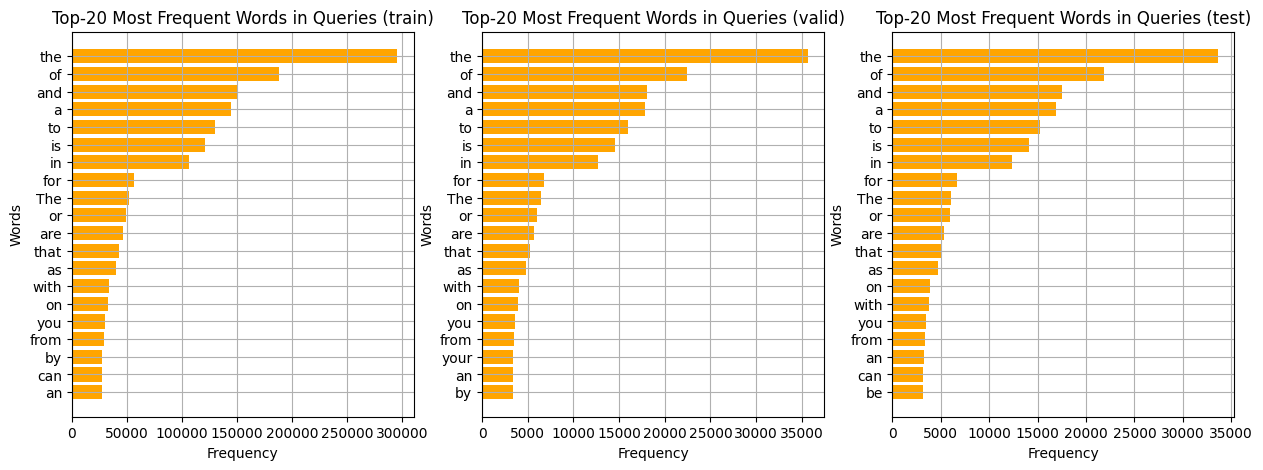

In [ ]:
# # Top-N Most Frequent Words in Passages
# def plot_top_words_in_passages(dataset, split_name, top_n=20):
#     all_passages = " ".join([p["passage_text"][0] for p in dataset["passages"]])
#     word_counts = Counter(all_passages.split())
#     most_common_words = word_counts.most_common(top_n)

#     words, counts = zip(*most_common_words)
#     plt.barh(words, counts, color="orange")
#     plt.gca().invert_yaxis()
#     plt.title(f"Top-{top_n} Most Frequent Words in Passages ({split_name})")
#     plt.xlabel("Frequency")
#     plt.ylabel("Words")
#     plt.show()

# # Plot top-20 words for train, validation, and test splits
# plot_top_words_in_passages(ms_marco_train, "Train")
# plot_top_words_in_passages(ms_marco_validation, "Validation")
# plot_top_words_in_passages(ms_marco_test, "Test")



def plot_top_words_in_passages(dataset_dict, top_n=20):
    fig, axes = plt.subplots(nrows=1, ncols=len(dataset_dict.keys()), figsize=(15, 5))

    for i, split_name in enumerate(dataset_dict.keys()):
        ax = axes[i]
        dataset = dataset_dict[split_name]
        all_passages = " ".join([p["passage_text"][0] for p in dataset["passages"]])
        word_counts = Counter(all_passages.split())
        most_common_words = word_counts.most_common(top_n)

        words, counts = zip(*most_common_words)
        ax.barh(words, counts, color="orange")
        ax.invert_yaxis()
        ax.set_title(f"Top-{top_n} Most Frequent Words in Queries ({split_name})")
        ax.set_xlabel("Frequency")
        ax.set_ylabel("Words")
        ax.grid(True)

    plt.show()

plot_top_words_in_passages({"train": ms_marco_train, "valid": ms_marco_validation, "test": ms_marco_test})

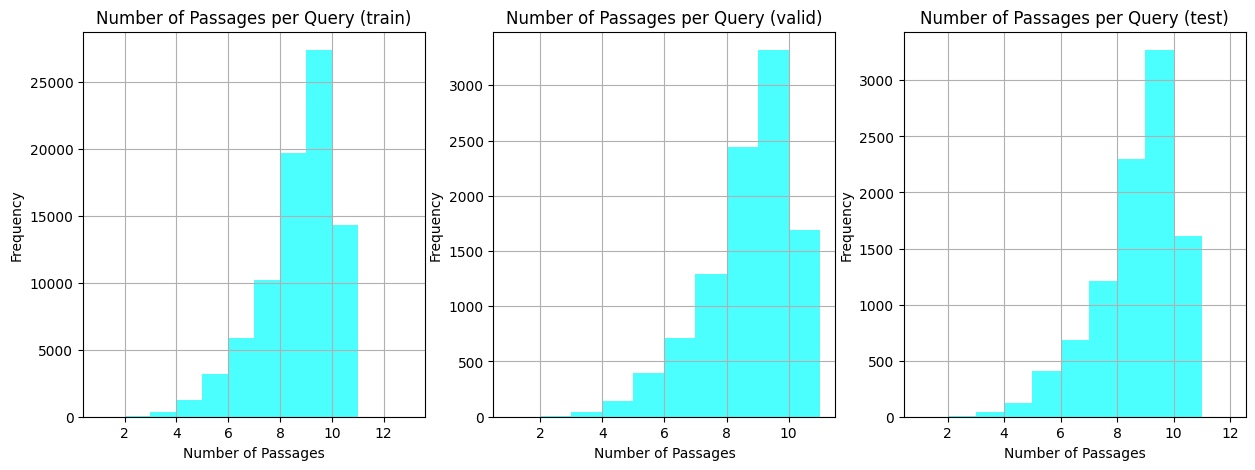

In [ ]:
# # Number of Passages per Query
# def analyze_passages_per_query(dataset, split_name):
#     num_passages = [len(p["passage_text"]) for p in dataset["passages"]]
#     plt.hist(num_passages, bins=range(1, max(num_passages) + 2), alpha=0.7, color="cyan")
#     plt.title(f"Number of Passages per Query ({split_name})")
#     plt.xlabel("Number of Passages")
#     plt.ylabel("Frequency")
#     plt.grid(True)
#     plt.show()

# # Analyze for train, validation, and test splits
# analyze_passages_per_query(ms_marco_train, "Train")
# analyze_passages_per_query(ms_marco_validation, "Validation")
# analyze_passages_per_query(ms_marco_test, "Test")


def analyze_passages_per_query(dataset_dict):
    fig, axes = plt.subplots(nrows=1, ncols=len(dataset_dict.keys()), figsize=(15, 5))

    for i, split_name in enumerate(dataset_dict.keys()):
        ax = axes[i]
        dataset = dataset_dict[split_name]

        num_passages = [len(p["passage_text"]) for p in dataset["passages"]]
        ax.hist(num_passages, bins=range(1, max(num_passages) + 2), alpha=0.7, color="cyan")
        ax.set_title(f"Number of Passages per Query ({split_name})")
        ax.set_xlabel("Number of Passages")
        ax.set_ylabel("Frequency")
        ax.grid(True)

    plt.show()

analyze_passages_per_query({"train": ms_marco_train, "valid": ms_marco_validation, "test": ms_marco_test})

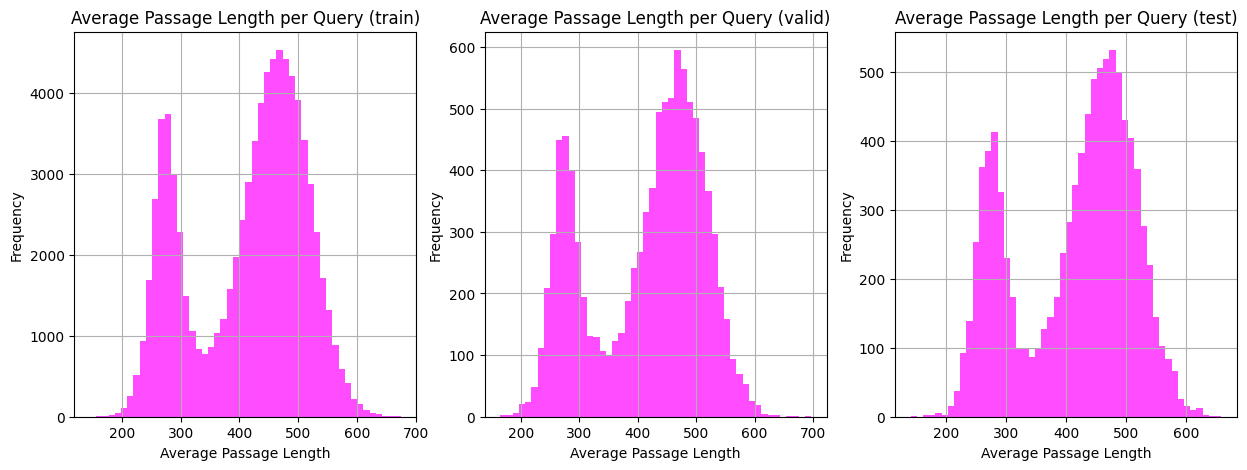

In [ ]:
# # Average Passage Length per Query
# def average_passage_length_per_query(dataset, split_name):
#     avg_lengths = [np.mean([len(passage) for passage in p["passage_text"]]) for p in dataset["passages"]]
#     plt.hist(avg_lengths, bins=50, alpha=0.7, color="magenta")
#     plt.title(f"Average Passage Length per Query ({split_name})")
#     plt.xlabel("Average Passage Length")
#     plt.ylabel("Frequency")
#     plt.grid(True)
#     plt.show()

# # Analyze for train, validation, and test splits
# average_passage_length_per_query(ms_marco_train, "Train")
# average_passage_length_per_query(ms_marco_validation, "Validation")
# average_passage_length_per_query(ms_marco_test, "Test")


def analyze_passages_per_query(dataset_dict):
    fig, axes = plt.subplots(nrows=1, ncols=len(dataset_dict.keys()), figsize=(15, 5))

    for i, split_name in enumerate(dataset_dict.keys()):
        ax = axes[i]
        dataset = dataset_dict[split_name]

        avg_lengths = [np.mean([len(passage) for passage in p["passage_text"]]) for p in dataset["passages"]]
        ax.hist(avg_lengths, bins=50, alpha=0.7, color="magenta")
        ax.set_title(f"Average Passage Length per Query ({split_name})")
        ax.set_xlabel("Average Passage Length")
        ax.set_ylabel("Frequency")
        ax.grid(True)

    plt.show()

analyze_passages_per_query({"train": ms_marco_train, "valid": ms_marco_validation, "test": ms_marco_test})

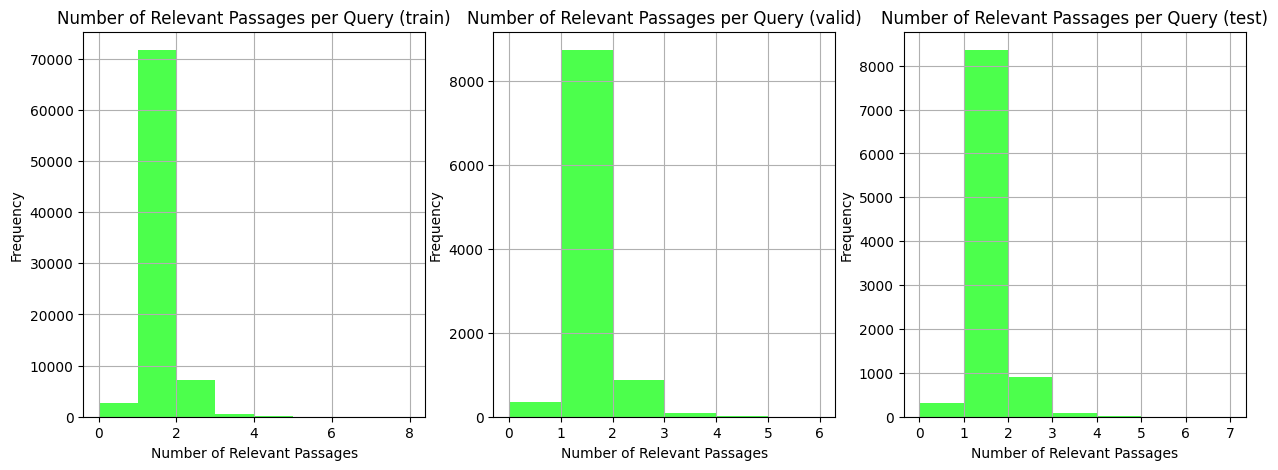

In [ ]:
# # Relevance Analysis: Number of Relevant Passages per Query
# def analyze_relevance_distribution(dataset, split_name):
#     relevant_counts = [sum(p["is_selected"]) for p in dataset["passages"]]
#     plt.hist(relevant_counts, bins=range(0, max(relevant_counts) + 2), alpha=0.7, color="lime")
#     plt.title(f"Number of Relevant Passages per Query ({split_name})")
#     plt.xlabel("Number of Relevant Passages")
#     plt.ylabel("Frequency")
#     plt.grid(True)
#     plt.show()

# # Analyze for train and validation splits (not test, as it may lack labels)
# analyze_relevance_distribution(ms_marco_train, "Train")
# analyze_relevance_distribution(ms_marco_validation, "Validation")





def analyze_relevance_distribution(dataset_dict):
    fig, axes = plt.subplots(nrows=1, ncols=len(dataset_dict.keys()), figsize=(15, 5))

    for i, split_name in enumerate(dataset_dict.keys()):
        ax = axes[i]
        dataset = dataset_dict[split_name]

        relevant_counts = [sum(p["is_selected"]) for p in dataset["passages"]]
        ax.hist(relevant_counts, bins=range(0, max(relevant_counts) + 2), alpha=0.7, color="lime")
        ax.set_title(f"Number of Relevant Passages per Query ({split_name})")
        ax.set_xlabel("Number of Relevant Passages")
        ax.set_ylabel("Frequency")
        ax.grid(True)

    plt.show()

analyze_relevance_distribution({"train": ms_marco_train, "valid": ms_marco_validation, "test": ms_marco_test})

In [ ]:
# Lexical Diversity: Calculate the ratio of unique words to total words as a measure of diversity.
def calculate_lexical_diversity(dataset, split_name):
    query_text = " ".join(dataset["query"])
    passage_text = " ".join([p["passage_text"][0] for p in dataset["passages"]])

    query_words = query_text.split()
    passage_words = passage_text.split()

    query_diversity = len(set(query_words)) / len(query_words)
    passage_diversity = len(set(passage_words)) / len(passage_words)

    print(f"{split_name} - Lexical Diversity (Queries): {query_diversity:.4f}")
    print(f"{split_name} - Lexical Diversity (Passages): {passage_diversity:.4f}")

# Calculate for train, validation, and test splits
calculate_lexical_diversity(ms_marco_train, "Train")
calculate_lexical_diversity(ms_marco_validation, "Validation")
calculate_lexical_diversity(ms_marco_test, "Test")

Train - Lexical Diversity (Queries): 0.0784
Train - Lexical Diversity (Passages): 0.0566
Validation - Lexical Diversity (Queries): 0.1818
Validation - Lexical Diversity (Passages): 0.1203
Test - Lexical Diversity (Queries): 0.1855
Test - Lexical Diversity (Passages): 0.1223


In [ ]:
# Initialize tokenizer
tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")

# Create data module
data_module = MSMarcoDataModule(
    train_data=ms_marco_train,
    validation_data=ms_marco_validation,
    test_data=ms_marco_test,
    tokenizer=tokenizer,
    batch_size=32
)

# Prepare datasets
data_module.setup()

# Access dataloaders
train_loader = data_module.train_dataloader()
val_loader = data_module.val_dataloader()
test_loader = data_module.test_dataloader()

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

In [ ]:
# Iterate through the training loader
for batch in train_loader:
    input_ids = batch["input_ids"]  # Tokenized input IDs
    attention_mask = batch["attention_mask"]  # Attention mask
    labels = batch["labels"]  # Labels for the batch
    print("Batch input_ids shape:", input_ids.shape)
    print("Batch attention_mask shape:", attention_mask.shape)
    print("Batch labels shape:", labels.shape)
    break  # Stop after printing one batch

## 3: (VANILLA) PREPROCESSING - GENERATE DATASET FOR DSI

The core idea is that the model must create associations between `queries` and `docids`.\
So let's start with a simple example without models and fluffy strange stuffs.\
Here, I'm going to use pairs of `(query, vanilla_tokenized_docid)`, but for our DSI we need `(pseudo-query, densly_tokenized_docid)`.

<h2>What do we have to do?</h2>

As the (second) paper mention, we need to construct a dataset $\mathcal{T}'$.\
To do so, we start from the generation of $$\mathcal{U} = \mathcal{O} \cup \mathcal{P}\qquad
\begin{cases}
\mathcal{O} = \bigcup_i \mathcal{O}_i = \bigcup_i \{d^1_i, d^2_i, \dots, d^m_i\}\\[10pt]
\mathcal{P} = \bigcup_i \mathcal{P}_i = \bigcup_i \{pq^1_i, pq^2_i, \dots, pq^m_i\}
\end{cases}$$
with
*   $d_i^j$ the $j$-th segment of the $i$-th document that belongs to the set $\mathcal{D}$ and
*   $pq_i^j$ the pseudo-query generated by [docT5query](https://github.com/castorini/docTTTTTquery) against the document segment $d_i^j$

then, having such computed $\mathcal{U}$, we need to filter it using a so called *'dense model'* named $M$. Due to its nature, dense retrieval models effectively preserve textual information in its representation (i.e. in its latent space), so they are perfect to address such task.

> We need to find a dense retrieval model open-source



<h2>How to filter?</h2>

We need to input individual fragment $t$ originating from the document of $id_t$ that belongs to $\mathcal{U}$ in our dense retrieval model $M$
$$t\in d_t = doc(id_t)\in \mathcal{U}$$
this process outputs a ranked list of $k$ elements
$$R_k(t, M) = (id^1, id^2,\dots, id^k)$$
if $id_t$ belongs to $R_k(t, M)$ this means that *'the fragment $t$ possessed keyinformation relevant to the original document'* and so can be included in the training corpus $\mathcal{T}'$.

In [ ]:
from transformers import T5Tokenizer, T5ForConditionalGeneration

# load a pretrained transformer
# DSI prefer generative-based transformers, so T5 will be good enough (also mentioned by the paper)
model_name = "t5-small"
tokenizer = T5Tokenizer.from_pretrained(model_name)
model = T5ForConditionalGeneration.from_pretrained(model_name)

In [ ]:
# use examples of document ids (docids) and documents
doc_ids = ["doc_001", "doc_002", "doc_003"]

# note, here documents are made by a single segment
# in genral we can have multiple segments belonging to the same document
documents = [
    "Deep learning is a subset of machine learning that uses neural networks.",
    "Reinforcement learning is a type of machine learning for decision-making.",
    "Transfer learning reuses pre-trained models to solve new tasks."
]

queries = [
    "What is deep learning?",
    "Explain reinforcement learning.",
    "How does transfer learning work?"
]

In [ ]:
# tokenize docids (vanilla tokenization, just for understanding)
def tokenize_doc_id(doc_id):
    return " ".join(list(doc_id.replace("_", " _ ")))

tokenized_doc_ids = [tokenize_doc_id(doc_id) for doc_id in doc_ids]
print("Tokenized Document IDs:", tokenized_doc_ids)

In [ ]:
# query-document pairs (note that we need pseudo-query)
training_data = [
    (query, doc_id) for query, doc_id in zip(queries, tokenized_doc_ids)
]

In [ ]:
training_data

After building the dataset $\mathcal{T'}$, we need to encode both the `docids` (in a semantically meaningful way) and the `pseudo-queries` in order to feed them in the DSI model; recall this is a vanilla code and we are going to encode (`query`, `vanilla_docid`) instead of (`pseudo-query`, `semantic_docid`).

To do so, we can use a simple tokenizer (ideally also the google T5)

In [ ]:
def prepare_inputs(query, tokenized_doc_id, tokenizer, max_length=512):
    # input: query
    input_encodings = tokenizer(
        query,
        max_length=max_length,
        truncation=True,
        padding="max_length",
        # pt stands for 'pytorch tensor'
        return_tensors="pt"
    )

    # output: tokenized_docid
    target_encodings = tokenizer(
        tokenized_doc_id,
        max_length=max_length,
        truncation=True,
        padding="max_length",
        # pt stands for 'pytorch tensor'
        return_tensors="pt"
    )

    return input_encodings, target_encodings

query, tokenized_doc_id = training_data[0]
input_encodings, target_encodings = prepare_inputs(query, tokenized_doc_id, tokenizer)

# print("Input Encodings:", input_encodings)
# print("Target Encodings:", target_encodings)

In [ ]:
# common practice: set decoder's start token ID to T5's default value
# (PAD token for now)
model.config.decoder_start_token_id = tokenizer.pad_token_id

### via GPT

In [ ]:
from transformers import T5Tokenizer, T5ForConditionalGeneration

# Load the docT5Query model and tokenizer
tokenizer = T5Tokenizer.from_pretrained("castorini/doc2query-t5-base-msmarco")
model = T5ForConditionalGeneration.from_pretrained("castorini/doc2query-t5-base-msmarco")

# Input passage or document
document = "The capital of France is Paris, known for its art, culture, and history."

# Tokenize input
input_ids = tokenizer(document, return_tensors="pt").input_ids

# Generate synthetic query
outputs = model.generate(input_ids, max_length=64, num_beams=4, length_penalty=1.0)
query = tokenizer.decode(outputs[0], skip_special_tokens=True)

print("Generated Query:", query)

## 3: (REAL) PREPROCESSING - GENERATE DATASET FOR DSI (HYBRID PIPELINE)

In [ ]:
# !pip install -q faiss-gpu
# !pip install -q faiss-gpu-cu12
!pip install -q faiss-cpu

# stable pyserini version
!pip install -q pyserini==0.21.0

# install openjdk 11
!apt-get -qq update
!apt-get -qq install -y openjdk-11-jdk
!java -version

# explicit verbose fault handler
import os
os.environ['PYTHONFAULTHANDLER'] = '1'

We are going to use the MSMARCO-100k, so we'll apply each of these stuffs on it.

1.   For the pseudo-queries generation, we can use the [docT5query](https://github.com/castorini/docTTTTTquery) from castorini
2.   As a *'dense retrieval model'* for ranking documents we can use the one proposed by castorini: [FAISS](https://github.com/castorini/pyserini/blob/master/docs/usage-search.md#faiss)
3.   For the segments extraction we can rely on a manually crafted approach


Let's try with sparse retrival model (Lucene), dense retrieval model (Faiss) and an hybrid approach based (see cell below).




### 3.1 DOCUMENT & QUERY EMBEDDING GENERATOR



The hybrid retrieval pipeline we propose combines **dense retrieval** (using FAISS) and **sparse retrieval** (using Lucene with BM25). The objective of this step is to rank documents based on both semantic similarity and lexical matching to achieve robust results.

---
As a first, step, we need to use a `SentenceTransformer` model to encode documents into dense vector embeddings, which are then indexed by FAISS.

- For a document $d_i$, the embedding is represented as:
  $$
  \mathbf{e}_{d_i} = f_{\text{dense}}(d_i)
  $$
  where $f_{\text{dense}}$ is the embedding function provided by the `SentenceTransformer` model.

- The embeddings of all documents are stored in a matrix:
  $$
  \mathbf{E} = [\mathbf{e}_{d_1}, \mathbf{e}_{d_2}, \dots, \mathbf{e}_{d_N}] \in \mathbb{R}^{N \times D}
  $$
  Here, $N$ is the number of documents, and $D$ is the embedding dimensionality.

Similarly, the query $q$ is encoded into a dense vector:
$$
\mathbf{e}_q = f_{\text{dense}}(q)
$$

In [11]:
import faiss
import numpy as np
from sentence_transformers import SentenceTransformer
from pyserini.search import SimpleSearcher

# Step 1: Generate Embeddings with SentenceTransformer
documents = [
    "Deep learning is a subset of machine learning that uses neural networks.",
    "Reinforcement learning is a type of machine learning for decision-making.",
    "Transfer learning reuses pre-trained models to solve new tasks."
]

queries = [
    "What is deep learning?",
    "Explain reinforcement learning.",
    "How does transfer learning work?"
]

# Load the SentenceTransformer model
embedding_model = SentenceTransformer('sentence-transformers/all-MiniLM-L6-v2')

# Generate document embeddings
document_embeddings = embedding_model.encode(documents, convert_to_numpy=True)

modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.7k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

### 3.2 FAISS DENSE RETRIEVAL MODEL






- **Index Creation**: The normalized document embeddings are added to a FAISS `IndexFlatIP` index.
- **Querying**: Given the query embedding $\mathbf{e}_q$, FAISS retrieves the top-$k$ documents based on inner product:
$$
\text{score}_{\text{FAISS}}(q, d_i) = \mathbf{e}_q \cdot \mathbf{e}_{d_i}
$$

The FAISS search returns:
- `indices`: The IDs of the top-$k$ documents.
- `distances`: The corresponding similarity scores.


#### 3.2.1 NORMALIZATION FOR COSINE SIMILARITY

FAISS uses **inner product** for similarity scoring by default. To ensure the scores are equivalent to cosine similarity, we apply a simple trick consisting in making both the document embeddings and the query embedding to be normalized:
$$
\mathbf{e}' = \frac{\mathbf{e}}{\|\mathbf{e}\|}
$$
Where $\|\mathbf{e}\|$ is the L2 norm of the embedding.

Normalized embeddings allow the inner product to behave like cosine similarity:
$$
\text{cosine_similarity}(\mathbf{e}_q, \mathbf{e}_{d_i}) = \mathbf{e}_q \cdot \mathbf{e}_{d_i}
$$

In [20]:
# Initialize FAISS Index
dim = document_embeddings.shape[1]  # Embedding dimensionality
faiss_index = faiss.IndexFlatIP(dim)  # Inner product for cosine similarity

# Normalize and add document embeddings to FAISS index
faiss.normalize_L2(document_embeddings)
faiss_index.add(document_embeddings)

# Step 2: Generate Query Embedding
query = "What is deep learning?"
query_embedding = embedding_model.encode([query], convert_to_numpy=True)
faiss.normalize_L2(query_embedding)

# Perform FAISS search
k = 3  # Number of results to retrieve
faiss_distances, faiss_indices = faiss_index.search(query_embedding, k)

# Print FAISS results
print("FAISS Results:")
for i, idx in enumerate(faiss_indices.squeeze()):
    print(f"Rank {i+1}: Document: {documents[idx]}, Distance: {faiss_distances.squeeze()[i]}")

FAISS Results:
Rank 1: Document: Deep learning is a subset of machine learning that uses neural networks., Distance: 0.8303160667419434
Rank 2: Document: Reinforcement learning is a type of machine learning for decision-making., Distance: 0.3908756971359253
Rank 3: Document: Transfer learning reuses pre-trained models to solve new tasks., Distance: 0.33839863538742065


In [ ]:
# from pyserini.encode import TctColBertQueryEncoder
# from pyserini.search.faiss import FaissSearcher

# encoder = TctColBertQueryEncoder('castorini/tct_colbert-v2-hnp-msmarco')
# faiss_searcher = FaissSearcher.from_prebuilt_index('msmarco-v1-passage', None)
# hits = faiss_searcher.search('what is a lobster roll')

# for i in range(0, 10):
#     print(f'{i+1:2} {hits[i].docid:7} {hits[i].score:.5f}')

### 3.3 LUCENE SPARSE RETRIEVAL MODEL


Lucene uses the **BM25** algorithm for sparse retrieval. For a query $q$ and document $d_i$, the BM25 relevance score is given by:
$$
\text{BM25}(q, d_i) = \sum_{t \in q} \text{IDF}(t) \cdot \frac{f(t, d_i) \cdot (k_1 + 1)}{f(t, d_i) + k_1 \cdot (1 - b + b \cdot \frac{|d_i|}{\text{avgdl}})}
$$
Where:
- $t$: A term in the query.
- $f(t, d_i)$: The frequency of term $t$ in document $d_i$.
- $|d_i|$: The length of the document.
- $\text{avgdl}$: The average document length in the corpus.
- $k_1$: Controls term frequency saturation (default $1.2$).
- $b$: Controls length normalization (default $0.75$).
- $\text{IDF}(t)$: The inverse document frequency of term $t$:
  $$
  \text{IDF}(t) = \log\left(\frac{N - n_t + 0.5}{n_t + 0.5} + 1\right)
  $$
  Where $N$ is the total number of documents and $n_t$ is the number of documents containing term $t$.




Pyserini retrieves the top-$k$ documents using BM25 scoring. The results include:
- `docid`: Document IDs.
- `BM25_score`: BM25 relevance scores.

---


In [61]:
#@title OLD (prebuilt index)
# Step 3: Perform Sparse Retrieval with Pyserini
lucene_searcher = SimpleSearcher.from_prebuilt_index("msmarco-passage")
lucene_searcher.set_bm25(k1=0.9, b=0.4)

# Sparse retrieval results
lucene_hits = lucene_searcher.search(query, k=5)
lucene_scores = {hit.docid: hit.score for hit in lucene_hits}

# Print Sparse Results
print("\nSparse Results (Lucene):")
for i, hit in enumerate(lucene_hits):
    doc = str(hit.raw.split(":")[2].rstrip("}").rstrip("\n").replace('"', ''))
    print(f"Rank {i+1}: Distance: {hit.score}, Document: {doc}")

Attempting to initialize pre-built index msmarco-passage.
/root/.cache/pyserini/indexes/index-msmarco-passage-20201117-f87c94.1efad4f1ae6a77e235042eff4be1612d already exists, skipping download.
Initializing msmarco-passage...


In [17]:
import os
import json
from pyserini.search import SimpleSearcher
from pyserini.search.lucene import LuceneSearcher
from pyserini.index import IndexReader


doc_ids = ["doc1", "doc2", "doc3"]

# Create a temporary JSONL file to hold the documents
jsonl_path = "documents.jsonl"
with open(jsonl_path, "w") as f:
    for doc_id, content in zip(doc_ids, documents):
        f.write(json.dumps({"id": doc_id, "contents": content}) + "\n")

# Step 2: Index the Documents with Pyserini
index_path = "lucene-index"
os.system(f"rm -rf {index_path}")  # Clean previous index if exists

# Build the Lucene index
os.system(f"python -m pyserini.index -collection JsonCollection "
          f"-generator DefaultLuceneDocumentGenerator "
          f"-threads 1 -input . -index {index_path} -storeRaw")

# Step 3: Perform Sparse Retrieval with LuceneSearcher
searcher = LuceneSearcher(index_path)

# Set BM25 parameters
searcher.set_bm25(k1=0.9, b=0.4)



# Search and display results for each query
lucene_hits = searcher.search("What is deep learning?", k=3)  # Top 3 results

for rank, hit in enumerate(lucene_hits):
    print(f"Rank {rank + 1}:")
    print(f"  DocID: {hit.docid}")
    print(f"  Score: {hit.score}")
    print(f"  Content: {hit.raw}")

Rank 1:
  DocID: doc1
  Score: 0.608299970626831
  Content: {
  "id" : "doc1",
  "contents" : "Deep learning is a subset of machine learning that uses neural networks."
}
Rank 2:
  DocID: doc2
  Score: 0.09350000321865082
  Content: {
  "id" : "doc2",
  "contents" : "Reinforcement learning is a type of machine learning for decision-making."
}
Rank 3:
  DocID: doc3
  Score: 0.06870000064373016
  Content: {
  "id" : "doc3",
  "contents" : "Transfer learning reuses pre-trained models to solve new tasks."
}


### 3.4 HYBRID RETRIEVAL MODEL


To leverage the strengths of both retrieval approaches, we combine the scores from FAISS and Lucene.

The combined score for each document is calculated through a **Linear Score Fusion**, i.e., as a weighted sum:
$$
\text{Combined_Score}(q, d_i) = \alpha \cdot \text{score}_{\text{FAISS}}(q, d_i) + (1 - \alpha) \cdot \text{BM25}(q, d_i)
$$
Where:
- $\alpha \in [0, 1]$: Weight parameter controlling the contribution of FAISS vs. BM25 scores.

In [25]:
# Step 4: Combine FAISS and Lucene Scores
alpha = 0.5
combined_scores = {}

# Add FAISS results to combined score dictionary
for i, idx in enumerate(faiss_indices.squeeze()):
    combined_scores[idx] = alpha * faiss_distances.squeeze()[i] + (1 - alpha) * lucene_hits[i].score


print(combined_scores.items())


# Sort by combined scores (dimension 1 contains scores)
ranked_results = sorted(combined_scores.items(), key=lambda x: x[1], reverse=True)

# Display Hybrid Ranked Results
print("\nHybrid Ranked Results:")
for rank, (doc_id, score) in enumerate(ranked_results, start=1):
    print(f"Rank {rank}: DocID: {doc_id}, Combined Score: {score:.4f}, Document: {documents[doc_id]}")

dict_items([(0, 0.7193080186843872), (1, 0.24218785017728806), (2, 0.2035493180155754)])

Hybrid Ranked Results:
Rank 1: DocID: 0, Combined Score: 0.7193, Document: Deep learning is a subset of machine learning that uses neural networks.
Rank 2: DocID: 1, Combined Score: 0.2422, Document: Reinforcement learning is a type of machine learning for decision-making.
Rank 3: DocID: 2, Combined Score: 0.2035, Document: Transfer learning reuses pre-trained models to solve new tasks.


<h2>Hierarchical Navigable Small Worls (HNSW)</h2>

RIVEDI

Due to the big amount of document we need to process, we opt for faster approximat nearest neighbor search exploited by FAISS.\
Since the original FAISS implementation uses the brute force approach, parsing a huge quantity of document can result in a prohibitive processing time; the addendum lead by approximat nearest neighbor search allows us to speed-up such operation without loosing to much in performances.


## STEPS SUMMARY



The documents are sorted in descending order of their combined scores to produce the final hybrid ranking.


1. **FAISS Dense Retrieval**:
   - Create embeddings with `SentenceTransformer`.
   - Normalize embeddings.
   - Search FAISS for top-$k$ results.

2. **Lucene Sparse Retrieval**:
   - Use Pyserini to query a Lucene index.
   - Retrieve BM25 scores for top-$k$ results.

3. **Score Fusion**:
   - Combine FAISS and BM25 scores with a weighted sum.
   - Sort documents by combined scores.



## Advantages of the Hybrid Approach

1. **Semantic Understanding**:
   - FAISS captures semantic relationships between queries and documents.
   - Example: "What is deep learning?" matches "Neural networks power deep learning."

2. **Lexical Precision**:
   - BM25 ensures term-matching precision.
   - Example: "What is deep learning?" prefers documents explicitly mentioning "deep learning."

3. **Robustness**:
   - The hybrid approach balances semantic and lexical relevance, reducing the risk of missing relevant documents.

## Mathematical Representation of the Pipeline


Given:
- $q$: Query.
- $\mathbf{E}$: Document embeddings.
- $\mathbf{e}_q$: Query embedding.

1. **FAISS Score**:
   $$
   \text{score}_{\text{FAISS}}(q, d_i) = \mathbf{e}_q \cdot \mathbf{e}_{d_i}
   $$

2. **BM25 Score**:
   $$
   \text{BM25}(q, d_i) = \sum_{t \in q} \text{IDF}(t) \cdot \frac{f(t, d_i) \cdot (k_1 + 1)}{f(t, d_i) + k_1 \cdot (1 - b + b \cdot \frac{|d_i|}{\text{avgdl}})}
   $$

3. **Hybrid Score**:
   $$
   \text{Combined_Score}(q, d_i) = \alpha \cdot \text{score}_{\text{FAISS}}(q, d_i) + (1 - \alpha) \cdot \text{BM25}(q, d_i)
   $$

## OLD 3.3 HYBRID APPROACH (FAISS + LUCENE)

In [ ]:
from typing import List, Dict

from pyserini.search.faiss import FaissSearcher, DenseSearchResult
from pyserini.search.lucene import LuceneSearcher


class HybridSearcher:
    """Hybrid Searcher for dense + sparse

        Parameters
        ----------
        dense_searcher : FaissSearcher
        sparse_searcher : LuceneSearcher
    """

    def _init_(self, dense_searcher, sparse_searcher):
        self.dense_searcher = dense_searcher
        self.sparse_searcher = sparse_searcher

    def search(self, query: str, k0: int = 10, k: int = 10, alpha: float = 0.1, normalization: bool = False, weight_on_dense: bool = False) -> List[DenseSearchResult]:
        dense_hits = self.dense_searcher.search(query, k0)
        sparse_hits = self.sparse_searcher.search(query, k0)
        return self._hybrid_results(dense_hits, sparse_hits, alpha, k, normalization, weight_on_dense)

    def batch_search(self, queries: List[str], q_ids: List[str], k0: int = 10, k: int = 10, threads: int = 1,
            alpha: float = 0.1, normalization: bool = False, weight_on_dense: bool = False) \
            -> Dict[str, List[DenseSearchResult]]:
        dense_result = self.dense_searcher.batch_search(queries, q_ids, k0, threads)
        sparse_result = self.sparse_searcher.batch_search(queries, q_ids, k0, threads)
        hybrid_result = {
            key: self._hybrid_results(dense_result[key], sparse_result[key], alpha, k, normalization, weight_on_dense)
            for key in dense_result
        }
        return hybrid_result

    @staticmethod
    def _hybrid_results(dense_results, sparse_results, alpha, k, normalization=False, weight_on_dense=False):
        dense_hits = {hit.docid: hit.score for hit in dense_results}
        sparse_hits = {hit.docid: hit.score for hit in sparse_results}
        hybrid_result = []
        min_dense_score = min(dense_hits.values()) if len(dense_hits) > 0 else 0
        max_dense_score = max(dense_hits.values()) if len(dense_hits) > 0 else 1
        min_sparse_score = min(sparse_hits.values()) if len(sparse_hits) > 0 else 0
        max_sparse_score = max(sparse_hits.values()) if len(sparse_hits) > 0 else 1

        for doc in set(dense_hits.keys()) | set(sparse_hits.keys()):

            if doc not in dense_hits:
                sparse_score = sparse_hits[doc]
                dense_score = min_dense_score
            elif doc not in sparse_hits:
                sparse_score = min_sparse_score
                dense_score = dense_hits[doc]
            else:
                sparse_score = sparse_hits[doc]
                dense_score = dense_hits[doc]

            if normalization:
                sparse_score = (sparse_score - (min_sparse_score + max_sparse_score) / 2) \
                               / (max_sparse_score - min_sparse_score)
                dense_score = (dense_score - (min_dense_score + max_dense_score) / 2) \
                              / (max_dense_score - min_dense_score)

            score = alpha * sparse_score + dense_score if not weight_on_dense else sparse_score + alpha * dense_score

            hybrid_result.append(DenseSearchResult(doc, score))
        return sorted(hybrid_result, key=lambda x: x.score, reverse=True)[:k]

ModuleNotFoundError: No module named 'pyserini.search.faiss'

## 4: MODEL

In [ ]:
class MSMarcoClassifier(pl.LightningModule):
    def __init__(self, model_name="bert-base-uncased", learning_rate=2e-5):
        super().__init__()
        self.model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=2)
        self.learning_rate = learning_rate

    def forward(self, input_ids, attention_mask):
        return self.model(input_ids=input_ids, attention_mask=attention_mask)

    def training_step(self, batch, batch_idx):
        outputs = self.model(
            input_ids=batch["input_ids"],
            attention_mask=batch["attention_mask"],
            labels=batch["label"]
        )
        loss = outputs.loss
        self.log("train_loss", loss, prog_bar=True)
        return loss

    def validation_step(self, batch, batch_idx):
        outputs = self.model(
            input_ids=batch["input_ids"],
            attention_mask=batch["attention_mask"],
            labels=batch["label"]
        )
        loss = outputs.loss
        self.log("val_loss", loss, prog_bar=True)
        return loss

    def configure_optimizers(self):
        return torch.optim.AdamW(self.parameters(), lr=self.learning_rate)


## 5: TRAINING

In [ ]:
# Model Checkpointing Callback.
checkpoint_callback = ModelCheckpoint(
    monitor="val_loss",  # Metric to monitor
    dirpath="checkpoints/",  # Directory to save checkpoints
    filename="best-checkpoint-{epoch:02d}-{val_loss:.2f}",  # Checkpoint name format
    save_top_k=1,  # Save only the best model
    mode="min"  # Minimize the monitored metric
)

# Early Stopping Callback.
early_stopping_callback = EarlyStopping(
    monitor="val_loss",  # Metric to monitor
    patience=3,  # Number of epochs without improvement to wait
    mode="min"  # Minimize the monitored metric
)

# Learning Rate Monitoring Callback.
lr_monitor = LearningRateMonitor(logging_interval="step")

# StochasticWeightAveraging Callback.
swa_callback = StochasticWeightAveraging()


# Device Statistics Callback
device_stats_callback = DeviceStatsMonitor()

# Trainer implementation.
trainer = Trainer(
    max_epochs=3,
    accelerator="gpu" if torch.cuda.is_available() else "cpu",
    devices=1 if torch.cuda.is_available() else None,
    enable_progress_bar=True,
    callbacks=[checkpoint_callback, early_stopping_callback, lr_monitor, swa_callback, device_stats_callback],
    gradient_clip_val=1.0,  # Clip gradients to this value
    precision=16,  # Enable 16-bit precision (AMP, Automatic Mixed Precision. Speed-Up Training and reduce Memory Usage)
)

In [ ]:
# Generate a timestamp for the run name
current_time = datetime.now().strftime("%Y-%m-%d_%H-%M-%S")

# Initialize WandB logger with the timestamp as the run name
wandb_logger = WandbLogger(
    project="IR_DSI",         # Shared project name
    name=f"run_{current_time}",     # Unique name based on the current time
    log_model=True                  # Log model artifacts
)

In [ ]:
# Initialize the model
model = MSMarcoClassifier()

# Initialize the Trainer.
trainer = Trainer(
    max_epochs=3,
    accelerator="gpu" if torch.cuda.is_available() else "cpu",
    devices=1 if torch.cuda.is_available() else None,
    enable_progress_bar=True,
    logger=wandb_logger,
)
# Train the model.
trainer.fit(model, data_module)

## 6: TESTING

In [ ]:
model.eval()  # Set model to evaluation mode
predictions = []
with torch.no_grad():
    for batch in test_loader:
        input_ids = batch["input_ids"].to("cuda" if torch.cuda.is_available() else "cpu")
        attention_mask = batch["attention_mask"].to("cuda" if torch.cuda.is_available() else "cpu")

        # Forward pass
        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        preds = torch.argmax(outputs.logits, dim=1)  # Predicted labels
        predictions.extend(preds.cpu().tolist())

print("Test Predictions:", predictions[:10])

# TRY DSI IMPLEMENTATION

In [ ]:
class MSMARCODataset(Dataset):
    def __init__(self, data, tokenizer, max_length=128):
        self.data = data
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        item = self.data[idx]
        query = item["query"]
        passage = item["passages"]["passage_text"][0]
        doc_id = int(item["query_id"])  # Convert query ID to an integer
        label = 1 if item["passages"]["is_selected"][0] else 0

        inputs = self.tokenizer(
            query,
            passage,
            truncation=True,
            padding="max_length",
            max_length=self.max_length,
            return_tensors="pt"
        )

        return {
            "input_ids": inputs["input_ids"].squeeze(0),
            "attention_mask": inputs["attention_mask"].squeeze(0),
            "doc_ids": torch.tensor(doc_id, dtype=torch.long),
            "label": torch.tensor(label, dtype=torch.long),
        }

In [ ]:
class MultiTaskDSIWithoutDistillation(pl.LightningModule):
    def __init__(self, model_name="t5-base", learning_rate=5e-4):
        super().__init__()
        self.save_hyperparameters()
        self.model = AutoModelForSeq2SeqLM.from_pretrained(model_name)
        self.learning_rate = learning_rate

        # Loss weights for multi-task learning
        self.indexing_loss_weight = 0.5
        self.retrieval_loss_weight = 0.5

    def forward(self, input_ids, attention_mask):
        return self.model(input_ids=input_ids, attention_mask=attention_mask)

    def compute_indexing_loss(self, outputs, doc_ids):
        """
        Indexing Task: Predict document IDs from passage text.
        """
        loss = F.cross_entropy(outputs.logits, doc_ids)
        return loss

    def compute_retrieval_loss(self, outputs, relevance_labels):
        """
        Retrieval Task: Rank passages based on relevance labels.
        """
        loss = F.cross_entropy(outputs.logits, relevance_labels)
        return loss

    def training_step(self, batch, batch_idx):
        # Forward pass
        outputs = self(
            input_ids=batch["input_ids"], attention_mask=batch["attention_mask"]
        )

        # Compute losses for indexing and retrieval
        indexing_loss = self.compute_indexing_loss(outputs, batch["doc_ids"])
        retrieval_loss = self.compute_retrieval_loss(outputs, batch["label"])

        # Combine losses with weights
        total_loss = (
            self.indexing_loss_weight * indexing_loss
            + self.retrieval_loss_weight * retrieval_loss
        )

        # Log losses
        self.log("train_indexing_loss", indexing_loss, prog_bar=True)
        self.log("train_retrieval_loss", retrieval_loss, prog_bar=True)
        self.log("train_total_loss", total_loss, prog_bar=True)

        return total_loss

    def validation_step(self, batch, batch_idx):
        # Forward pass
        outputs = self(
            input_ids=batch["input_ids"], attention_mask=batch["attention_mask"]
        )

        # Compute losses for indexing and retrieval
        indexing_loss = self.compute_indexing_loss(outputs, batch["doc_ids"])
        retrieval_loss = self.compute_retrieval_loss(outputs, batch["label"])

        # Combine losses
        total_loss = (
            self.indexing_loss_weight * indexing_loss
            + self.retrieval_loss_weight * retrieval_loss
        )

        # Log losses
        self.log("val_indexing_loss", indexing_loss, prog_bar=True)
        self.log("val_retrieval_loss", retrieval_loss, prog_bar=True)
        self.log("val_total_loss", total_loss, prog_bar=True)

        return total_loss

    def configure_optimizers(self):
        return torch.optim.AdamW(self.parameters(), lr=self.learning_rate)

In [ ]:
import torch
import torch.nn.functional as F
from transformers import AutoModelForSeq2SeqLM

class MultiTaskDSIWithDistillation(pl.LightningModule):
    def __init__(self, student_model_name="t5-base", teacher_model=None, learning_rate=5e-4):
        super().__init__()
        self.save_hyperparameters()

        # Student model (docT5query or similar)
        self.student = AutoModelForSeq2SeqLM.from_pretrained(student_model_name)

        # Teacher model (dense retriever like ColBERT or BM25)
        self.teacher = teacher_model  # Pre-trained model used for distillation

        self.learning_rate = learning_rate

        # Separate heads for multi-task learning
        self.indexing_head = torch.nn.Linear(self.student.config.hidden_size, 10000)  # 10,000 doc IDs
        self.retrieval_head = torch.nn.Linear(self.student.config.hidden_size, 2)  # Binary classification

        # Loss weights for tasks
        self.indexing_loss_weight = 0.5
        self.retrieval_loss_weight = 0.3
        self.distillation_loss_weight = 0.2

    def forward(self, input_ids, attention_mask):
        encoder_outputs = self.student.encoder(input_ids=input_ids, attention_mask=attention_mask).last_hidden_state
        indexing_logits = self.indexing_head(encoder_outputs[:, 0, :])  # Use [CLS] token
        retrieval_logits = self.retrieval_head(encoder_outputs[:, 0, :])  # Use [CLS] token
        return indexing_logits, retrieval_logits

    def compute_indexing_loss(self, logits, doc_ids):
        return F.cross_entropy(logits, doc_ids)

    def compute_retrieval_loss(self, logits, relevance_labels):
        return F.cross_entropy(logits, relevance_labels)

    def compute_distillation_loss(self, student_logits, teacher_logits):
        """
        Knowledge distillation loss: KL divergence between student and teacher logits.
        """
        student_probs = F.log_softmax(student_logits, dim=-1)
        teacher_probs = F.softmax(teacher_logits, dim=-1)
        return F.kl_div(student_probs, teacher_probs, reduction="batchmean")

    def training_step(self, batch, batch_idx):
        # Forward pass through student model
        indexing_logits, retrieval_logits = self(input_ids=batch["input_ids"], attention_mask=batch["attention_mask"])

        # Compute task-specific losses
        indexing_loss = self.compute_indexing_loss(indexing_logits, batch["doc_ids"])
        retrieval_loss = self.compute_retrieval_loss(retrieval_logits, batch["label"])

        # Compute distillation loss (if teacher model is provided)
        if self.teacher:
            with torch.no_grad():
                teacher_logits = self.teacher(input_ids=batch["input_ids"], attention_mask=batch["attention_mask"]).logits
            distillation_loss = self.compute_distillation_loss(retrieval_logits, teacher_logits)
        else:
            distillation_loss = 0.0

        # Combine losses
        total_loss = (
            self.indexing_loss_weight * indexing_loss
            + self.retrieval_loss_weight * retrieval_loss
            + self.distillation_loss_weight * distillation_loss
        )

        # Log losses
        self.log("train_indexing_loss", indexing_loss, prog_bar=True)
        self.log("train_retrieval_loss", retrieval_loss, prog_bar=True)
        self.log("train_distillation_loss", distillation_loss, prog_bar=True)
        self.log("train_total_loss", total_loss, prog_bar=True)

        return total_loss

    def configure_optimizers(self):
        return torch.optim.AdamW(self.parameters(), lr=self.learning_rate)

# OLD

## I-PYSERINI INSPECTION

In [ ]:
from pyserini.search import get_topics

topics = get_topics('msmarco-passage-dev-subset')
print(f'{len(topics)} queries total')

In [ ]:
from pyserini.search import SimpleSearcher

searcher = SimpleSearcher.from_prebuilt_index('msmarco-passage')

# Search the index for a query
hits = searcher.search('What is machine learning?')

# Display the top-ranked results
for i, hit in enumerate(hits):
    print(f"Rank {i+1}: {hit.docid} - {hit.score}")
    print(hit.raw)

## 2: BERT EMBEDDING

In [ ]:

# Load a pre-trained model for embeddings
tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")
model = AutoModel.from_pretrained("bert-base-uncased")

# Generate embeddings for documents
def embed_text(text):
    inputs = tokenizer(text, return_tensors="pt", truncation=True, padding=True)
    with torch.no_grad():
        outputs = model(**inputs)
    return outputs.last_hidden_state.mean(dim=1).squeeze().numpy()

## Model Implementation

### T5 Transformer

In [ ]:
from transformers import T5Tokenizer, T5ForConditionalGeneration, TrainingArguments, TrainerCallback

model_name = "t5-base"

tokenizer = T5Tokenizer.from_pretrained(model_name, cache_dir='cache')
model = T5ForConditionalGeneration.from_pretrained(model_name, cache_dir='cache')

### Bert (12 layers)
For docids embedding generation

In [ ]:
!pip install transformers

In [ ]:
import torch
from transformers import BertTokenizer, BertModel

# Load pre-trained BERT model and tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertModel.from_pretrained('bert-base-uncased')

In [ ]:
# Set model to evaluation mode
model.eval()

text = "Transformers are powerful models for NLP tasks."
inputs = tokenizer(text, return_tensors='pt', truncation=True, padding=True)

# Display tokenized input
print(inputs)

### Inputs2Target

In [ ]:
class IndexingTrainDataset(Dataset):
    def _init_(self, path_to_data, max_length, cache_dir, tokenizer):
        super()._init_()

        self.train_data = datasets.load_dataset(
            'json',
            data_files=path_to_data,
            ignore_verifications=False,
            cache_dir=cache_dir
        )['train']

        self.max_length = max_length
        self.tokenizer = tokenizer
        self.total_len = len(self.train_data)


    def _getitem_(self, idx):
        # Retrieve document data
        doc = self.data[idx]
        doc_text = doc['text']
        docid = doc['docid']

        # Tokenize input (document text)
        # BertTokenizer.from_pretrained('bert-base-uncased')
        source = self.tokenizer(
            doc_text,
            max_length=self.max_length,
            padding='max_length',
            truncation=True,
            return_tensors='pt'
        )

        # Tokenize target (docid)
        target = self.tokenizer(
            docid,
            max_length=10,
            padding='max_length',
            truncation=True,
            return_tensors='pt'
        )

        # Prepare input-output pair
        return {
            'input_ids': source['input_ids'].squeeze(),
            'attention_mask': source['attention_mask'].squeeze(),
            'labels': target['input_ids'].squeeze()
        }

### Training

In [ ]:
training_args = TrainingArguments(
    output_dir="./results",
    learning_rate=0.0005,
    warmup_steps=10000,
    # weight_decay=0.01,
    per_device_train_batch_size=128,
    per_device_eval_batch_size=128,
    evaluation_strategy='steps',
    eval_steps=1000,
    max_steps=1000000,
    dataloader_drop_last=False,  # necessary
    report_to='wandb',
    logging_steps=50,
    save_strategy='no',
    # fp16=True,  # gives 0/nan loss at some point during training, seems this is a transformers bug.
    dataloader_num_workers=10,
    # gradient_accumulation_steps=2
)

trainer = IndexingTrainer(
    model=model,
    tokenizer=tokenizer,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=eval_dataset,
    data_collator=IndexingCollator(
        tokenizer,
        padding='longest',
    ),
    compute_metrics=compute_metrics,
    callbacks=[QueryEvalCallback(test_dataset, wandb, restrict_decode_vocab, training_args, tokenizer)],
    restrict_decode_vocab=restrict_decode_vocab
)

trainer.train()

### Training (from GPT)

In [ ]:
import torch
from transformers import T5ForConditionalGeneration, T5Tokenizer, Trainer, TrainingArguments
from datasets import load_dataset
import wandb

# Initialize Weights & Biases (W&B) for logging
wandb.init(project="DSI-Training")

# 1. Load the Pre-trained T5 Model and Tokenizer
model_name = "t5-base"
tokenizer = T5Tokenizer.from_pretrained(model_name)
model = T5ForConditionalGeneration.from_pretrained(model_name)

# 2. Prepare the Dataset
class IndexingTrainDataset(torch.utils.data.Dataset):
    def _init_(self, data, tokenizer, max_length=128):
        self.data = data
        self.tokenizer = tokenizer
        self.max_length = max_length

    def _len_(self):
        return len(self.data)

    def _getitem_(self, idx):
        item = self.data[idx]
        doc_text = item['text']
        docid = item['docid']

        # Tokenize the document text (input)
        source = self.tokenizer(
            doc_text,
            max_length=self.max_length,
            padding='max_length',
            truncation=True,
            return_tensors='pt'
        )

        # Tokenize the document ID (target)
        target = self.tokenizer(
            docid,
            max_length=10,
            padding='max_length',
            truncation=True,
            return_tensors='pt'
        )

        # Prepare input-output pair
        return {
            'input_ids': source['input_ids'].squeeze(),
            'attention_mask': source['attention_mask'].squeeze(),
            'labels': target['input_ids'].squeeze()
        }

# Load your dataset (e.g., Natural Questions)
dataset = load_dataset("path/to/your/dataset")
train_data = IndexingTrainDataset(dataset['train'], tokenizer)
eval_data = IndexingTrainDataset(dataset['validation'], tokenizer)

# 3. Define Training Arguments
training_args = TrainingArguments(
    output_dir="./dsi_checkpoints",
    evaluation_strategy="steps",
    eval_steps=500,
    logging_dir="./logs",
    logging_steps=100,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=3,
    learning_rate=2e-5,
    weight_decay=0.01,
    save_steps=1000,
    save_total_limit=2,
    report_to="wandb"  # Enable logging to W&B
)

# 4. Initialize Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_data,
    eval_dataset=eval_data,
    tokenizer=tokenizer
)

# 5. Start Training
trainer.train()

# 6. Save the Fine-tuned Model
model.save_pretrained("./fine_tuned_dsi")
tokenizer.save_pretrained("./fine_tuned_dsi")

# 7. End Logging with W&B
wandb.finish()